<div dir="rtl" lang="fa" style="text-align: center;">
<p>
<b>
<center>
تمرین سوم پردازش زبان طبیعی<br>
نیمسال دوم<br>
گروه ۱۲<br>
</b>
</p>
</div>


In [17]:
!pip install torch transformers seqeval datasets pytorch-crf


<div dir="rtl" lang="fa" style="text-align: center;">
<p>

1. **بارگذاری دیتاست‌ها**
    - از دیتاست "conll2003" استفاده می‌شود.
    - دیتاست‌های آموزشی، اعتبارسنجی و تست به صورت جداگانه بارگذاری می‌شوند.
    - برای این کار از متد `load_dataset` با پارامترهای مناسب استفاده می‌شود.

2. **بارگذاری توکنایزر BERT**
    - مدل توکنایزر `bert-base-cased` بارگذاری می‌شود.
    - از کلاس `BertTokenizer` برای این منظور استفاده می‌شود.

3. **بارگذاری مدل BERT**
    - مدل `bert-base-cased` بارگذاری می‌شود.
    - از کلاس `BertModel` برای این کار استفاده می‌شود.

In [2]:
from datasets import load_dataset
from transformers import BertTokenizer, BertModel
from keras.preprocessing.sequence import pad_sequences
from datasets import load_dataset

train_dataset = load_dataset("conll2003", split='train', trust_remote_code=True)
valid_dataset = load_dataset("conll2003", split='validation', trust_remote_code=True)
test_dataset = load_dataset("conll2003", split='test', trust_remote_code=True)

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
bert_model = BertModel.from_pretrained('bert-base-cased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

<div dir="rtl" lang="fa" style="text-align: center;">
<p>

1. **تعریف تابع `tokenize_and_preserve_labels`**
    - کلمات جمله و برچسب‌های متنی را به توکن‌ها تبدیل کرده و برچسب‌ها را حفظ می‌کند.
    - برای هر کلمه، توکن‌ها و برچسب‌های مربوطه را تولید می‌کند.

2. **تعریف تابع `preprocess_dataset`**
    - پردازش دیتاست برای آماده‌سازی جهت استفاده در مدل BERT.
    - شامل مراحل زیر است:
      1. استخراج جملات و برچسب‌های NER از دیتاست.
      2. تبدیل برچسب‌ها از اعداد به برچسب‌های متنی.
      3. توکن‌سازی جملات و حفظ برچسب‌ها.
      4. پد کردن `input_ids` برای یکسان‌سازی طول جملات.
      5. پد کردن برچسب‌ها برای یکسان‌سازی طول برچسب‌ها.
      6. ایجاد `attention_masks` برای مشخص کردن توکن‌های واقعی.


In [3]:
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
import torch
import itertools

def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        tokenized_sentence.extend(tokenized_word)
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels


def preprocess_dataset(dataset, max_len = 60):
    sentences = dataset['tokens']
    tags = dataset['ner_tags']

    tags = [label_encoder.inverse_transform(tag_seq) for tag_seq in tags]

    tokenized_texts_and_labels = [
        tokenize_and_preserve_labels(sent, labs)
        for sent, labs in zip(sentences, tags)
    ]

    tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
    labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

    input_ids_padded = pad_sequences([tokenizer.convert_tokens_to_ids(text) for text in tokenized_texts],
                                     maxlen=max_len, dtype="long", value=0.0, truncating="post", padding="post")

    labels_padded = pad_sequences([[tag2idx.get(label) for label in label_sequence] for label_sequence in labels],
                                  maxlen=max_len, value=tag2idx["PAD"], padding="post",
                                  dtype="long", truncating="post")

    attention_masks = [[float(token_id != 0.0) for token_id in sequence] for sequence in input_ids_padded]

    return input_ids_padded, labels_padded, attention_masks


<div dir="rtl" lang="fa" style="text-align: center;">
<p>

1. **تعریف و آماده‌سازی `LabelEncoder`**
    - ایجاد `LabelEncoder` برای تبدیل برچسب‌ها به برچسب‌های متنی.
    - جمع‌آوری تمام برچسب‌ها از دیتاست‌های آموزشی، اعتبارسنجی و تست و فلت کردن آنها.
    - آموزش `LabelEncoder` با برچسب‌های جمع‌آوری شده.

2. **ایجاد مقادیر برچسب یکتا و نگاشت برچسب به ایندکس**
    - جمع‌آوری و فلت کردن تمام برچسب‌ها از دیتاست‌های مختلف.
    - استخراج مقادیر یکتای برچسب‌ها.
    - تبدیل مقادیر یکتای برچسب‌ها به برچسب‌های متنی با استفاده از `LabelEncoder`.
    - افزودن برچسب "PAD" به مقادیر یکتا.
    - ایجاد نگاشت از برچسب‌ها به ایندکس‌ها.



In [4]:
label_encoder = LabelEncoder()
flattened_tags = list(itertools.chain.from_iterable(train_dataset['ner_tags'] + valid_dataset['ner_tags'] + test_dataset['ner_tags']))
label_encoder.fit(flattened_tags)

flattened_tags = list(itertools.chain(*train_dataset['ner_tags'], *valid_dataset['ner_tags'], *test_dataset['ner_tags']))
unique_tag_values = list(set(flattened_tags))
unique_tag_values = label_encoder.inverse_transform(unique_tag_values).tolist()
unique_tag_values.append("PAD")

tag2idx = {tag: index for index, tag in enumerate(unique_tag_values)}


<div dir="rtl" lang="fa" style="text-align: center;">
<p>

1. **تعریف تابع `find_max_sentence_length`**
    - ایجاد تابعی که طولانی‌ترین جمله را در دیتاست پیدا می‌کند.
    - برای هر جمله، طول آن را محاسبه کرده و بیشترین مقدار را به عنوان طولانی‌ترین جمله برمی‌گرداند.

2. **یافتن طولانی‌ترین جمله در هر دیتاست**
    - استفاده از تابع `find_max_sentence_length` برای یافتن طولانی‌ترین جمله در دیتاست‌های آموزشی، اعتبارسنجی و تست.

3. **یافتن طولانی‌ترین جمله کلی**
    - محاسبه طولانی‌ترین جمله کلی از میان طولانی‌ترین جملات هر دیتاست.

4. **چاپ طولانی‌ترین جمله‌ها**
    - نمایش طولانی‌ترین جمله در هر دیتاست و طولانی‌ترین جمله کلی.


In [5]:
def find_max_sentence_length(dataset):
    max_length = 0
    for tokens in dataset['tokens']:
        max_length = max(max_length, len(tokens))
    return max_length

max_length_train = find_max_sentence_length(train_dataset)
max_length_valid = find_max_sentence_length(valid_dataset)
max_length_test = find_max_sentence_length(test_dataset)

max_length = max(max_length_train, max_length_valid, max_length_test)

print(f"Maximum sentence length in train dataset: {max_length_train}")
print(f"Maximum sentence length in valid dataset: {max_length_valid}")
print(f"Maximum sentence length in test dataset: {max_length_test}")
print(f"Overall maximum sentence length: {max_length}")


Maximum sentence length in train dataset: 113
Maximum sentence length in valid dataset: 109
Maximum sentence length in test dataset: 124
Overall maximum sentence length: 124


<div dir="rtl" lang="fa" style="text-align: center;">
<p>

1. **تعریف تابع `get_sentence_lengths`**
    - ایجاد تابعی که طول هر جمله را در دیتاست محاسبه می‌کند.
    - طول جملات به صورت لیست برگردانده می‌شود.

2. **دریافت طول جملات برای هر دیتاست**
    - استفاده از تابع `get_sentence_lengths` برای محاسبه طول جملات در دیتاست‌های آموزشی، اعتبارسنجی و تست.

3. **ترسیم هیستوگرام**
    - ایجاد نمودار هیستوگرام برای نمایش توزیع طول جملات.
    - تنظیم اندازه شکل نمودار.
    - تعیین بازه‌های طول جملات (bins) بر اساس حداکثر طول جملات در دیتاست‌ها.
    - رسم هیستوگرام‌ها برای هر دیتاست با رنگ‌های مختلف و شفافیت تنظیم شده.
    - تنظیم برچسب‌های محورهای x و y و عنوان نمودار.
    - افزودن راهنما (legend) برای تشخیص هر دیتاست.
    - تنظیم برچسب‌های محور x برای نمایش هر 5 واحد.
    - نمایش نمودار.


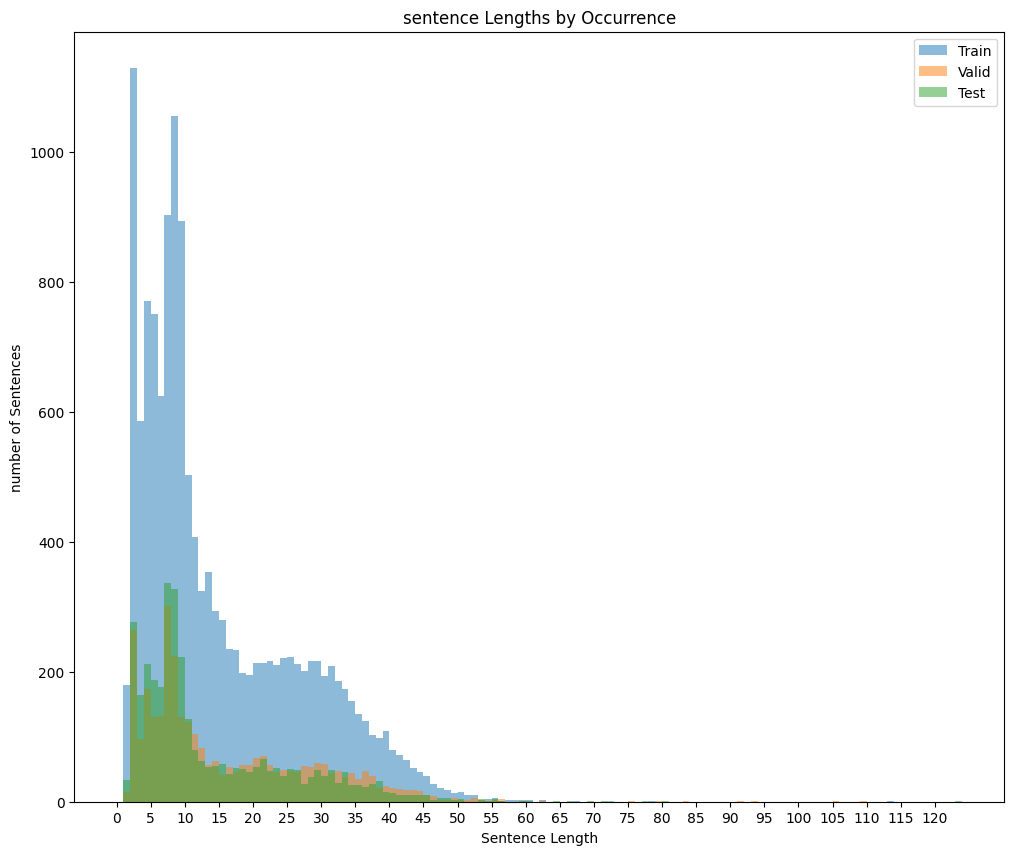

In [6]:
import matplotlib.pyplot as plt

def get_sentence_lengths(dataset):
    return [len(tokens) for tokens in dataset['tokens']]

train_lengths = get_sentence_lengths(train_dataset)
valid_lengths = get_sentence_lengths(valid_dataset)
test_lengths = get_sentence_lengths(test_dataset)

plt.figure(figsize=(12, 10))

bins = range(0, max(max(train_lengths), max(valid_lengths), max(test_lengths)) + 1, 1)

plt.hist(train_lengths, bins=bins, alpha=0.5, label='Train')
plt.hist(valid_lengths, bins=bins, alpha=0.5, label='Valid')
plt.hist(test_lengths, bins=bins, alpha=0.5, label='Test')
plt.xlabel('Sentence Length')
plt.ylabel('number of Sentences')
plt.title('sentence Lengths by Occurrence')
plt.legend(loc='upper right')
plt.xticks(range(0, max(max(train_lengths), max(valid_lengths), max(test_lengths)) + 1, 5))
plt.show()


In [7]:
len(flattened_tags)

301418

In [8]:
tag2idx

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 'PAD': 9}

<div dir="rtl" lang="fa" style="text-align: center;">
<p>

1. **پیش‌پردازش دیتاست‌ها**
    - فراخوانی تابع `preprocess_dataset` برای دیتاست‌های آموزشی، اعتبارسنجی و تست.
    - دریافت `input_ids` پد شده، برچسب‌های پد شده و `attention_masks`.

2. **تبدیل به تنسور**
    - تبدیل `input_ids`، برچسب‌ها و `attention_masks` هر دیتاست به تنسورهای PyTorch.

3. **ایجاد DataLoader ها**
    - ایجاد `TensorDataset` برای دیتاست‌های آموزشی، اعتبارسنجی و تست.
    - تعریف `RandomSampler` برای دیتاست آموزشی.
    - تعریف `SequentialSampler` برای دیتاست‌های اعتبارسنجی و تست.
    - ایجاد `DataLoader` برای هر دیتاست با استفاده از `TensorDataset` و `Sampler` مناسب.


In [9]:
train_inputs_padded, train_labels_padded, train_attention_masks = preprocess_dataset(train_dataset)
valid_inputs_padded, valid_labels_padded, valid_attention_masks = preprocess_dataset(valid_dataset)
test_inputs_padded, test_labels_padded, test_attention_masks = preprocess_dataset(test_dataset)

# Convert to tensors
train_inputs = torch.tensor(train_inputs_padded)
train_tags = torch.tensor(train_labels_padded)
train_masks = torch.tensor(train_attention_masks)

valid_inputs = torch.tensor(valid_inputs_padded)
valid_tags = torch.tensor(valid_labels_padded)
valid_masks = torch.tensor(valid_attention_masks)

test_inputs = torch.tensor(test_inputs_padded)
test_tags = torch.tensor(test_labels_padded)
test_masks = torch.tensor(test_attention_masks)

# Create DataLoaders
train_data = TensorDataset(train_inputs, train_masks, train_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=32)

valid_data = TensorDataset(valid_inputs, valid_masks, valid_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=32)

test_data = TensorDataset(test_inputs, test_masks, test_tags)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=32)


In [10]:
indexx = 123
train_inputs[indexx], train_tags[indexx]

(tensor([  138,  3129, 11608,  1113,  9170,  5762,   170,  3129, 27629, 27109,
          2592,  1142,  1989,  1115, 13135,  1108, 11676,  6300, 12083,  1116,
          1106,  1620,  3129, 13318,  1774,  1106,  1862,  1313,  1170,  1684,
          1107,  1103,  1456,  2170,  1583,   119,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]),
 tensor([0, 7, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 7, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 0, 0, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
         9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]))

In [11]:
print(f"Number of training samples: {len(train_data)}")
print(f"Number of validation samples: {len(valid_data)}")
print(f"Number of test samples: {len(test_data)}")

Number of training samples: 14041
Number of validation samples: 3250
Number of test samples: 3453


<div dir="rtl" lang="fa" style="text-align: center;">
در این بخش، یک مدل ترکیبی شامل LSTM و CRF برای برچسب‌گذاری توالی‌ها تعریف شده است. این مدل از لایه‌های تعبیه‌سازی، LSTM دوطرفه و CRF برای پیش‌بینی برچسب‌های توالی‌ها استفاده می‌کند.

1. کلاس `Embedding_LSTM_CRF`برای ایجاد یک مدل ترکیبی از LSTM و CRF برای برچسب‌گذاری توالی‌ها.
   - مدل شامل لایه‌های تعبیه‌سازی (Embedding)، LSTM دوطرفه (Bidirectional LSTM)، لایه خطی (Linear Layer) و CRF است.

2. - در متد فوروارد تعریف عملیات پیش‌رو (Forward Pass) مدل را داریم.
     - **Embedding:** تبدیل توکن‌های ورودی به بردارهای تعبیه‌سازی.
     - **LSTM:** پردازش بردارهای تعبیه‌سازی با LSTM دوطرفه.
     - **Linear Layer:** تبدیل خروجی LSTM به امتیازهای برچسب‌ها.
     - **CRF:** محاسبه توالی برچسب‌های بهینه یا محاسبه خسارت (در صورت موجود بودن برچسب‌ها).

In [18]:
import torch
import torch.nn as nn
from transformers import BertModel
from torchcrf import CRF

class Embedding_LSTM_CRF(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, tagset_size):
        super(Embedding_LSTM_CRF, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.hidden2tag = nn.Linear(hidden_dim * 2, tagset_size)
        self.crf = CRF(tagset_size, batch_first=True)

    def forward(self, input_ids, attention_mask, tags=None):
        embeds = self.embedding(input_ids)
        lstm_out, _ = self.lstm(embeds)
        emissions = self.hidden2tag(lstm_out)

        if tags is not None:
            loss = -self.crf(emissions, tags, mask=attention_mask.byte(), reduction='mean')
            return loss
        else:
            return self.crf.decode(emissions, mask=attention_mask.byte())


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vocab_size = tokenizer.vocab_size
embedding_dim = 128
hidden_dim = 256
tagset_size = len(tag2idx)

model = Embedding_LSTM_CRF(vocab_size, embedding_dim, hidden_dim, tagset_size)
model.to(device)

Embedding_LSTM_CRF(
  (embedding): Embedding(28996, 128)
  (lstm): LSTM(128, 256, batch_first=True, bidirectional=True)
  (hidden2tag): Linear(in_features=512, out_features=10, bias=True)
  (crf): CRF(num_tags=10)
)

<div dir="rtl" lang="fa" style="text-align: center;">
در این بخش، مدل `Embedding_LSTM_CRF` آموزش داده شده و عملکرد آن ارزیابی می‌شود. این مراحل شامل آموزش مدل، ارزیابی عملکرد و محاسبه معیارهای ارزیابی است.

- بهینه‌سازی وزن‌های مدل با استفاده از Adam.

این بخش از کد، فرآیند آموزش و ارزیابی مدل `Embedding_LSTM_CRF` را به تفصیل انجام می‌شود. مدل با استفاده از مجموعه داده‌های آموزشی آموزش داده شده و عملکرد آن با استفاده از مجموعه داده‌های ارزیابی سنجیده می‌شود. معیارهای ارزیابی شامل دقت، یادآوری، F1 (ماکرو و میکرو) و دقت محاسبه و گزارش می‌شوند.

In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np

def evaluate(model, dataloader):
    model.eval()
    predictions, true_labels = [], []

    for batch in dataloader:
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            logits = model(input_ids, attention_mask)

        predictions.extend(logits)
        true_labels.extend(labels.cpu().numpy())

    return predictions, true_labels

def calculate_metrics(predictions, true_labels, tag2idx):
    idx2tag = {idx: tag for tag, idx in tag2idx.items()}

    true_tags = [idx2tag[idx] for seq in true_labels for idx in seq if idx != tag2idx["PAD"]]
    pred_tags = [idx2tag[idx] for seq in predictions for idx in seq if idx != tag2idx["PAD"]]

    precision = precision_score(true_tags, pred_tags, average='macro')
    recall = recall_score(true_tags, pred_tags, average='macro')
    f1_macro = f1_score(true_tags, pred_tags, average='macro')
    f1_micro = f1_score(true_tags, pred_tags, average='micro')
    accuracy = accuracy_score(true_tags, pred_tags)

    return precision, recall, f1_macro, f1_micro, accuracy


optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def train(model, dataloader, optimizer):
    model.train()
    total_loss = 0

    for batch in dataloader:
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        model.zero_grad()

        loss = model(input_ids, attention_mask, labels)
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(dataloader)
    return avg_loss

num_epochs = 10

for epoch in range(num_epochs):
    train_loss = train(model, train_dataloader, optimizer)

    predictions, true_labels = evaluate(model, valid_dataloader)
    precision, recall, f1_macro, f1_micro, accuracy = calculate_metrics(predictions, true_labels, tag2idx)

    print(f"Epoch {epoch + 1}")
    print(f"Train loss: {train_loss}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Macro: {f1_macro}")
    print(f"F1 Micro: {f1_micro}")
    print(f"Accuracy: {accuracy}")

/usr/local/lib/python3.10/dist-packages/torchcrf/__init__.py:249: UserWarning: where received a uint8 condition tensor. This behavior is deprecated and will be removed in a future version of PyTorch. Use a boolean condition instead. (Triggered internally at ../aten/src/ATen/native/TensorCompare.cpp:530.)
  score = torch.where(mask[i].unsqueeze(1), next_score, score)


Epoch 1
Train loss: 11.247364339632977
Precision: 0.7112520027001152
Recall: 0.5540982892049517
F1 Macro: 0.6128714004376523
F1 Micro: 0.8814639800285307
Accuracy: 0.8814639800285307
Epoch 2
Train loss: 4.526356934958004
Precision: 0.8231041651232933
Recall: 0.6745381417914544
F1 Macro: 0.7351916420841051
F1 Micro: 0.916874702805516
Accuracy: 0.916874702805516
Epoch 3
Train loss: 2.334739624231986
Precision: 0.8598835779865815
Recall: 0.7246119305173989
F1 Macro: 0.7823894019088036
F1 Micro: 0.9288813599619591
Accuracy: 0.9288813599619591
Epoch 4
Train loss: 1.179609424296707
Precision: 0.8437036420031324
Recall: 0.7624687077513277
F1 Macro: 0.79737897203646
F1 Micro: 0.9373662624821684
Accuracy: 0.9373662624821684
Epoch 5
Train loss: 0.5741801152943479
Precision: 0.8477799959979087
Recall: 0.7775066774287372
F1 Macro: 0.809246755948811
F1 Micro: 0.9402787684260581
Accuracy: 0.9402787684260581
Epoch 6
Train loss: 0.26467748010077075
Precision: 0.8464228667164035
Recall: 0.7757336588277